Two posts ago, [I implemented a Hierarchical Bayesian model of the Premier League.](http://danielweitzenfeld.github.io/passtheroc/blog/2014/10/28/bayes-premier-league/) The model, introduced by Gianluca Baio and Marta A. Blangiardo, modeled scoring in soccer as a Poisson process, with the log scoring intensities a linear function of the teams' attacking/defending strengths plus a home field advantage.  By fitting the model to the league as a whole, they are able to estimate teams' attacking strengths while 'controlling' for the defending strengths of their opponents, and vice versa.

Since writing that post, I've wanted to reproduce the model for (American) football.  But a Poisson process isn't as natural of a fit for football as it is for soccer.  It wouldn't to capture the fight-for-field-position process of football.  Moreover, because football is more structured, we have more data to work with: we can get much more granular than the game-outcome level.

In this post, I describe a model of the football drive as a piecewise exponential competing risks survival model.  I then fit an example implementation, embedding the drive model within a Hierarchical Bayesian model of the NFL.  

### The Piecewise Exponential Competing Risks Survival Model

I learned about the piecewise exponential model via the course materials of [Germán Rodríguez](http://data.princeton.edu), who is based at the Office of Population Research at Princeton.  Rodriquez calls it his "favorite model in the context of competing risks," and I'm borrowing heavily from him in this explanation of the model; see [here (pdf)](http://data.princeton.edu/pop509/CompetingRisks.pdf) and [here](http://data.princeton.edu/wws509/notes/c7s4.html).

The model assumes there are intervals, each of which has a constant baseline hazard rate.
With intervals $0 = \tau_1 < \tau_2 < ... < \tau_{k} = \infty$, the baseline hazard for death by cause $j$ is a step function: $$\lambda_{j0}(t) = \lambda_{jk},  \text{for } t \in [\tau_k, \tau_{k+1})$$ 

Bringing in covariates $x$ and coefficients $beta_j$, the hazard rate for cause $j$ at time $t$ in interval $k$ is: $$\lambda_j(t,x) = \lambda_{j0}(t)e^{x'\beta_j} = e^{\alpha_{jk} + x'\beta_j}$$
where $\alpha_{jk} = \text{log }\lambda_{jk}$ is the log baseline risk for cause $j$ in interval $k$.

Thus, failures of type $j$ in interval $k$ to people with covariate values $x_i$ are are distributed Poisson with mean $$\mu_{ijk} = E_{ik}e^{\alpha_{jk} + x'_i\beta_j} $$ where $E_{ik}$ is the total exposure of people with covariates $x_i$ in interval $k$ (to all causes).  In other words, the likelihood function asks, 'how probable is it that we'd see $failures_{ijk}$ in a $Poisson(\mu_{ijk})$ distribution?', for every combination of $i$, $j$, $k$. (Note that this means covariates have to be discretized.)

What makes the model handy for competing risk is that for the overall risk, just sum over the causes: $$\lambda(t,x) = \sum_{j=1}^m\lambda_j(t,x) = \sum_{j=1}^me^{\alpha_{jk} + x'\beta_j} $$

And given an observed death, the conditional probability that the death was by cause $j$ is just $j$'s risk divided by the overall risk: $$\pi_{jk} = \frac{e^{\alpha_{jk} + x'\beta_j}}{\sum_{r=1}^me^{\alpha_{rk} + x'\beta_r}}$$

#### Application to Football: Yards Instead of Years

Survival analysis is usually concerned with an entity's survival in time.  Here, we'll look at a drive's survival in yards.  Drives that move backwards will be counted as 0-yard drives. 


#### Application to Football: The Intervals-As-Regions-On-the-Field Trick

In a conventional application of the piecewise exponential survival model, the constant-baseline-risk intervals are age intervals - e.g. 0-1 months, 1-3 months, 3-6 months, etc. That is, they are relative to the entity whose survival is being modeled. 

But there's no reason these intervals have to be a relative to the entity. In the case of the football drive, they can represent fixed regions of the football field itself.  

The idea is to pick areas on the field that have a similar baseline hazard rate.  Intuitively, this means picking areas on the field within which an offense or a defense is going to think similarly, especially with regard to risk averseness.   So, for example, I defined the following intervals, where yards 51 and up indicate the opponent's territory:

0. 0-13 yards: offense pinned against their goalline, so has to call quick-developing plays
1. 13-75 yards: the 'normal' zone   
2. 75-100 yards: 'extended red-zone'; offense thinks 'worse case, we kick a field goal' and focuses on ball control; defense has very small area to worry about

So if a drive starts on the 10 yard line and wants to survive to the endzone, it has to survive the interval-0 hazard rate for 3 yards, the interval-1 rate for 62 yards, and the interval-2 rate for 25 yards.  If a drive starts on the 77, it only has to survive the interval-2 hazard rate for 23 yards.  And so on. 

Intuitively, it's like a drive has to run a gauntlet, with a difficulty that varies by zone. To be clear, the gauntlet is such that each zone isn't pass/fail, but rather death-by-exposure, so that it can occur anywhere within the zone - indeed, it's more likely to occur earlier in the zone than later.  

#### Application to Football: Competing Risks for a Drive

A drive can die by 'running out of steam' - a punt, field goal attempt, unsuccessful 4th down attempt - or by a turnover.  While there's no requirement to do so, I model these two causes as competing risks because they have different consequences for the starting field position of the other team.  Also, the piecewise baseline hazard rates probably vary: imagine a team focusing more on ball control as it gets closer to the endzone, knowing that as long as they retain the ball, they can kick a field goal.   

#### Application to Football: Covariates

Covariates can include team-specific parameters (attacking strength, home field advantage), team-interval-specific parameters (red zone attacking strength), drive-situation-specific parameters (weather, game situation (is the offense team losing badly, or down by just a score?)), and game-specific parameters (importance).  This flexibility is a key strength of the model.  


### Weaknesses

As an approach to modeling football, it has (at least) these weaknesses:

* it makes no distinction between run vs. pass
* it cannot represent drives that end 'before' they began - e.g. a drive starting on the 20 but ending on the 10 because of a sack or penalty.  No safeties.
* it doesn't include special teams, although this could be remedied by adding a special-teams model
* it doesn't account for clock management


## Example Implementation

In the remainder of the post, I show the results of an example implementation of the model.  I've embedded the drive model within a Hierarchical Bayesian framework, so that team-specific parameters are drawn from common distributions.  

I fit the model to 2014 regular season data from [NFLsavant](http://nflsavant.com/about.php).

### Intervals

I used the following constant-baseline-risk intervals.  Note that yards 50+ are in the opponent's territory. 

0. 0-13 yards
1. 13-75 yards 
2. 66-100 yards

### Covariates: Drive Death by Punt/Field Goal

I used team-specific attacking/defending 'strength' covariates.  My first attempts suffered from overshrinkage (see  [my earlier post](http://danielweitzenfeld.github.io/passtheroc/blog/2014/10/28/bayes-premier-league/) for a discussion of shrinkage in Hierarchical Bayesian models), so I tried the technique used by Baio/Blangiardo in their [second model](http://www.statistica.it/gianluca/Research/BaioBlangiardo.pdf) of the Seria A: 

> One possible way to avoid this problem is to introduce a more complicated structure for the parameters of the model, in order to allow for three different generating mechanism, one for the top teams, one for the mid-table teams, and one for the bottom-table teams. Also, in line with Berger (1984), shrinkage can be limited by modelling the attack and defense parameters using a non central t (nct) distribution on ν = 4 degrees of freedom instead of the normal of § 2.

Using $t$ to indicate team, first we define latent group parameters $grp^{att}(t)$ and $grp^{def}(t)$, with Dirichlet(1,1,1) priors. Team specific attacking and defending strengths are modelled as:
 $$att_t \sim nct(\mu_{grp(t)}^{att}, \tau_{grp(t)}^{att}, \nu)$$
 $$def_t \sim nct(\mu_{grp(t)}^{def}, \tau_{grp(t)}^{def}, \nu)$$

To associate the latent groups with a performance tier, the priors on the $\mu$s constrain them to be positive/negative.  In this example specification, a negative coefficient means a lower hazard (longer drive), while a positive coeffience means a higher hazard (shorter drive).  So for the 'top' group, the priors are:
$$\mu_1^{att} \sim truncNormal(0, 0.001, -3, 0)$$
$$\mu_1^{def} \sim truncNormal(0, 0.001, 0, 3)$$

 And for the 'bottom' group, the priors are:
$$\mu_3^{att} \sim truncNormal(0, 0.001, 0, 3)$$
$$\mu_3^{def} \sim truncNormal(0, 0.001, -3, 0)$$


I fix $\mu_2^{att}$ and $\mu_2^{def}$ to 0, unlike Baio/Blangiardo, who draw them from a Normal distribution. 

Each set ($att$s and $def$s) is subject to a sum-to-zero contraint, e.g. $\sum_{t=1}^Tatt_t = 0$.

These covariates are used in all zones:  

* Team-specific home field advantage, applied when the defending team is home.  Home parameters are drawn from $Normal(\mu_{home}, \sigma_{home})$.  Unlike the other team-specific parameters, $home_t$ is not subject to a sum-to-zero constraint.  (In future work, I'll try giving the attacking team a home advantage as well).  
* $offense\_winning\_greatly$, a binary flag indicating whether the team possessing the ball is winning by more than 16 points. 
* $offense\_losing\_badly$, a binary flag indicating whether the team poessessing the ball is losing by more than 16 points. 
* $two\_minute\_drill$, a binary flag indicating whether the drive began in the last two minutes of a half.

### Covariates: Drive Death by Turnover

Because we observe fewer deaths-by-turnover, we should cut down on the covariates to make sure the model is identifiable.  With that in mind, the covariates I used in this implementation are:

* Team specific ball-retention abilities $att_t \sim Normal(0, \sigma_{att})$
* Home field advantage, applied when the defending team is home.  Note that it's not team-specific here.
* $offense\_winning\_greatly$, a binary flag indicating whether the team possessing the ball is winning by more than 16 points. 
* $offense\_losing\_badly$, a binary flag indicating whether the team poessessing the ball is losing by more than 16 points. 
* $two\_minute\_drill$, a binary flag indicating whether the drive began in the last two minutes of a half.

## Assessing Model Fit with Simulation

In order to simulate a game, we have to make some assumptions.  The major assumptions are: 

* Special Teams 
  
  * There are no kickoff returns, all kickoffs result in a touchback. 
  * If a drive dies by punt/field goal, the team on offense kicks a field goal is they're passed some point on the field (I used 66), and all field goals attempts are good.
  * A punt and return net always net out to some constant number of yards (I used 38).

* The Clock
  
  * The clock time elapsed by a drive is a linear function of the drive distance.
  * Touchdowns, field goals, and punts all take a certain constant amount of time off the clock.

* Ties
  
  * Ties are decided by coin flip. 
  
The ties assumption is easily fixed, but I haven't had the chance yet. Simulation code is [here](https://github.com/DanielWeitzenfeld/passtheroc_source/tree/master/content/downloads/notebooks/nfl_hierarchical_bayes). 

After fitting the example implementation on 2014 regular season data, and using these assumptions, I used the model to simulate the 2014 season 900 times. For each simulated season, I drew a set of parameter values from the posterior distribution.

The model + simulation recreates some macro-level features of football, such as the distribution of drive starting points.  I think the discrepency here is largely driven by my assuming away special teams, although again, this could be remedied by a sub model. 

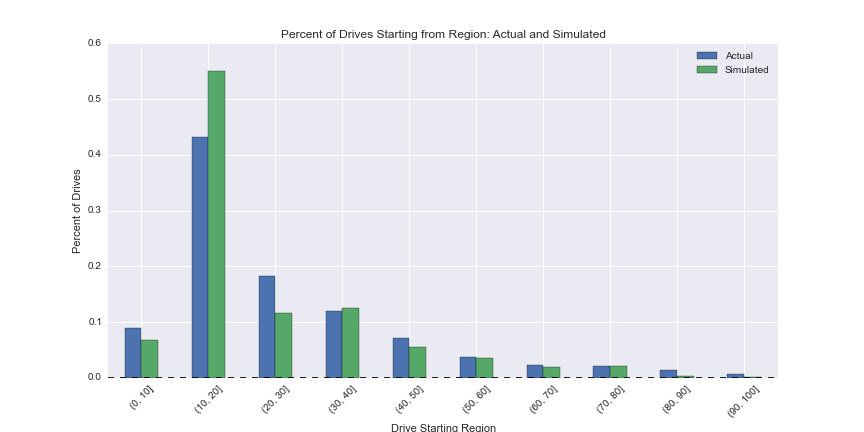

In [7]:
Image(CHART_DIR + 'drives_by_starting_region.png')

Drive outcome by starting point is similarly close, although the simulations have a slight bias toward drive success when a drive begins after the 50.  This could be a result of a small sample size of observed drives (see chart above).  Alternatively, it could be drive momentum.  Of the drives that make it to the red zone, the vast majority started between the 20 and 40 (see chart above), so these drives could be pulling the baseline redzone hazard rate downward.  It would be interesting to include a drive-age covariate to see if this is real. 

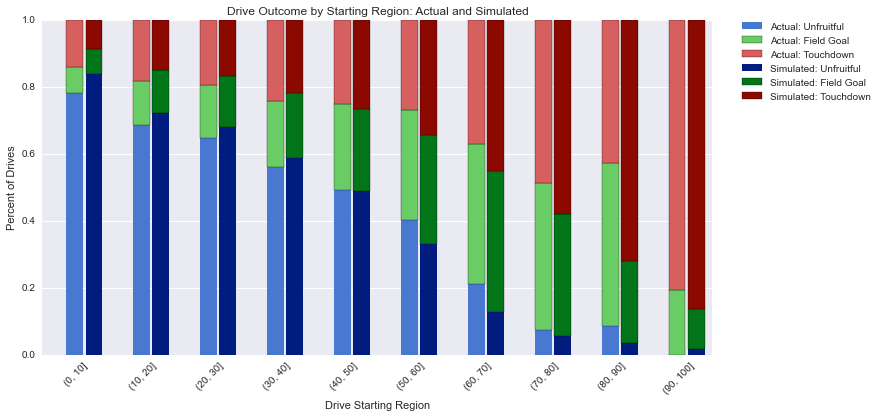

In [8]:
Image(CHART_DIR + 'drive_outcome_by_starting_region.png')

Same chart, wider regions, same bias:

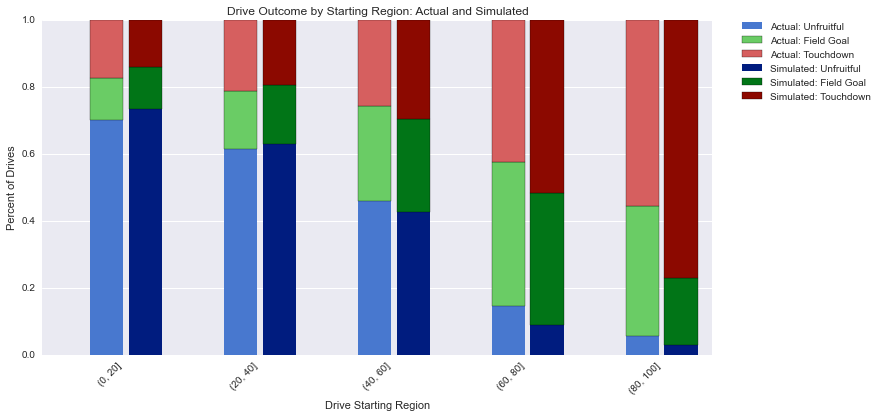

In [9]:
Image(CHART_DIR + 'drive_outcome_by_starting_region_wider_regions.png')

We can compare the actual season-level stats with the results from the simulations.  We see some shrinkage, even with the three-tier heirarchy generating the team-specific parameters.  Another interpretation would be that teams for which there is a large differential between simulated and actual wins actually just got lucky or unlucky: Washington, for example, lost some close games. 

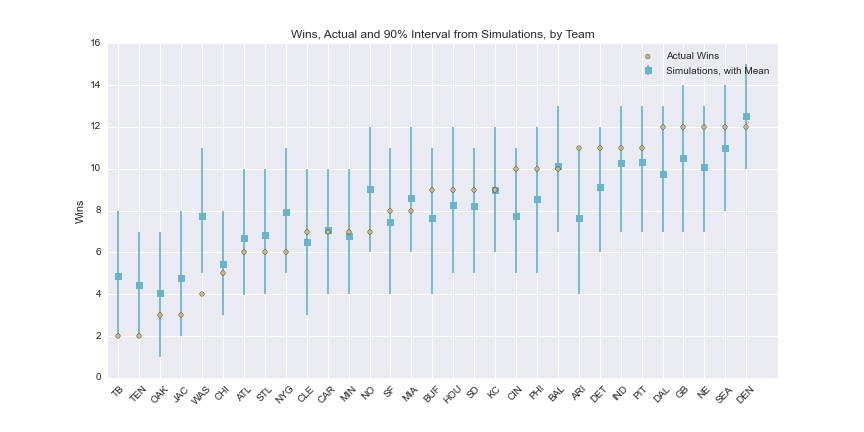

In [10]:
Image(CHART_DIR + 'wins_actual_simulated.png')

Offensive yards:  

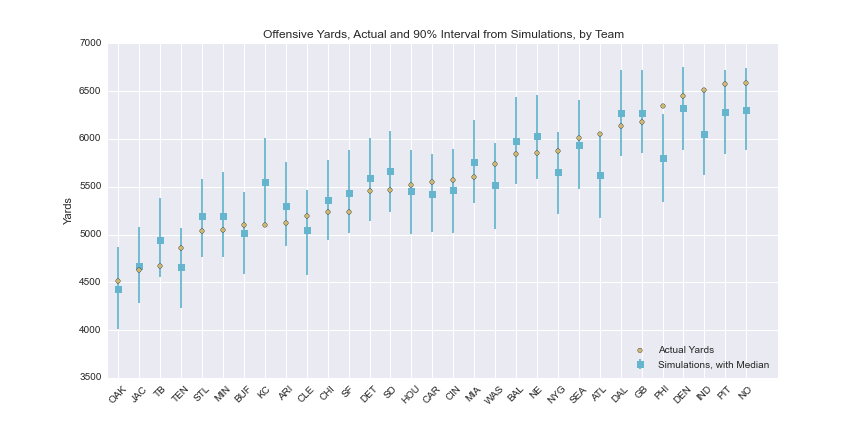

In [11]:
Image(CHART_DIR + 'yards_actual_simulated.png')

We can also look at the underlying parameters being fed into the simulation, like the attack strength parameter.  Some things to keep in mind when looking at this chart:

* Negative value = lower drive hazard = better attack
* Y-axis units are roughly '% better/worse than mean team'
* Strength of defense, home field advantage, and drive context (large score differential) are being controlled for

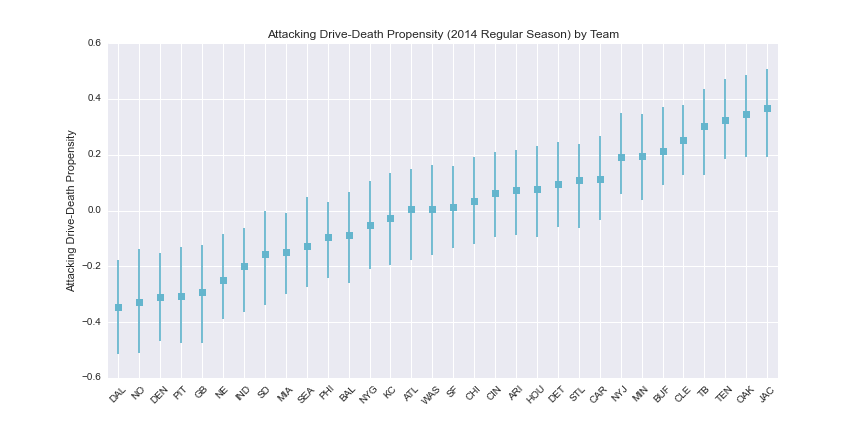

In [12]:
Image(CHART_DIR + 'attacking_strength_with_intervals.png')

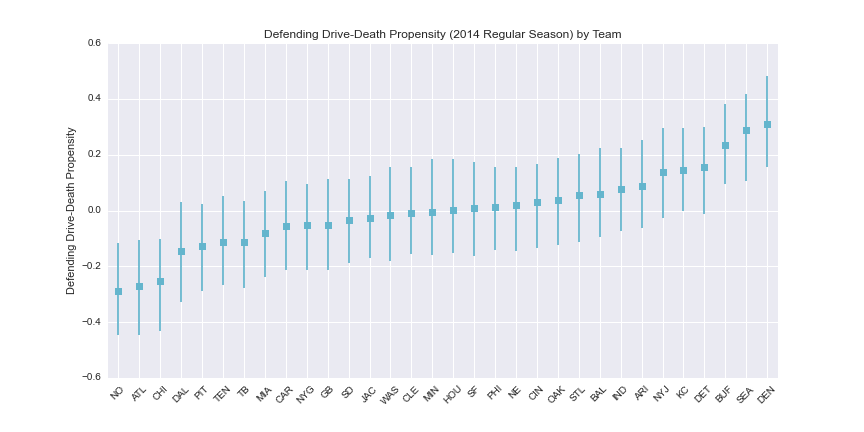

In [13]:
Image(CHART_DIR + 'defending_strength_with_intervals.png')

### Obligatory Deflategate Chart: Turnover Propensity

There's been some discussion about whether the Patriot's low giveaway numbers are so improbable as to be evidence of something fishy.  My model finds no evidence that NE's 2014 giveaway propensity is an outlier relative to the other teams. 

The intervals on this chart are noticable wider than on the attacking 'quality' chart above.  This is because turnovers are extremely rare relative to 'natural' drive deaths like punts and field goals, so we have a lot less to go on.  

The obvious next step is to include multiple year's worth of data.

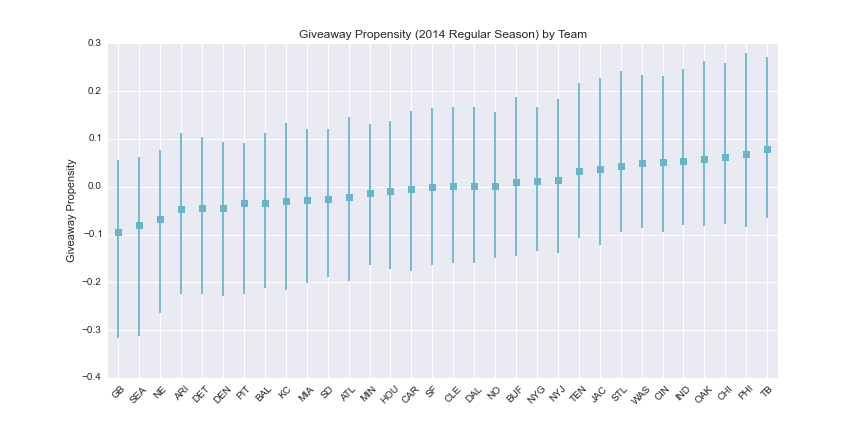

In [15]:
Image(CHART_DIR + 'turnover_propensity_with_intervals.png')

### Simulated Win Rate Against Median Team

To assess a team's overall quality, I simulate each team playing a hypothetical 33rd team, the Median Team, 1000 times.  Win rates are charted below.  Keep in mind that the model hasn't seen the postseason.

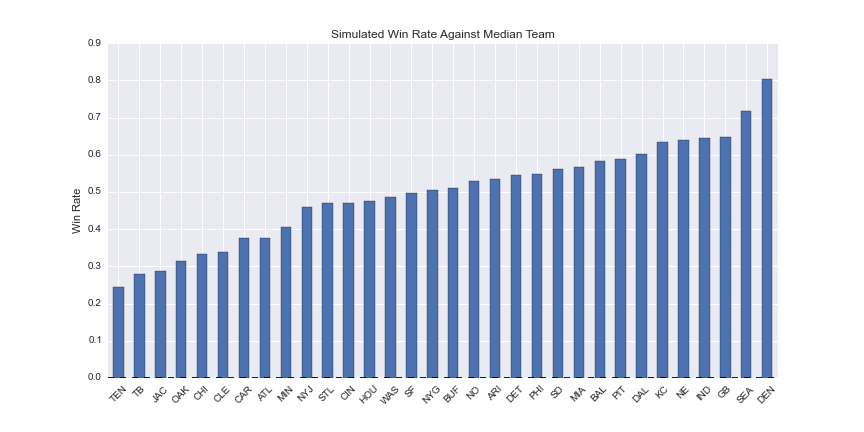

In [16]:
Image(CHART_DIR + 'simulated_win_rate_against_median_team.png')

### Strength of Schedule
I estimate strength of schedule by having the median team play each team's schedule through 500 times, and look at the mean number of losses by schedule.  Poor Oakland.

These results are comparable with [the prediction machine](http://www.predictionmachine.com/Strength-of-Schedule-Rankings).

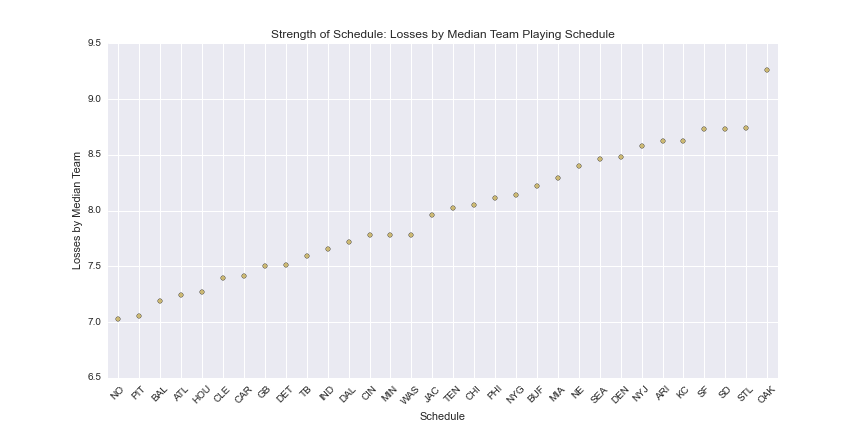

In [17]:
Image(CHART_DIR + 'strength_of_schedule.png')

### Obligatory Superbowl Prediction
My implementation of the model is clearly hot on SEA over NE. Keep in mind that it hasn't seen the postseason.  That said, when I simulate a neutral-field match up 50000 times, SEA wins 58% of the time.

## Appendix: PyMC code for the Ex-Turnover model

In [ ]:
import os
import sys


CHART_DIR = os.path.join(os.getcwd(), 'charts/')
sys.path.append(os.getcwd())

import math
import warnings

warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import pymc as pm

CODE_DIR = os.path.join(os.getcwd(), 'code/')
DATA_DIR = os.path.join(os.getcwd(), 'data/')
DPI = 300
WIDECHARTWIDTH = 10
WIDECHARTHEIGHT = 6
SAVECHARTS = False


from nfl_hierarchical_bayes import data_prep, simulation_pwexp, elapsed_time, REDZONE_PIECE



# three tiers for attack/defense parameters
# no redzone breakout

df = pd.read_csv(DATA_DIR + 'pbp-2014-bugfixed.csv')
df = data_prep.enrich_play_level_df(df)
df = data_prep.merge_in_game_level_dataset(df, data_prep.GAME_LEVEL_DATASET_2014)
df = data_prep.calculate_game_score_at_play_start(df)
df_drive = data_prep.generate_drive_df(df)
df_drive, teams = data_prep.index_with_team_indexes(df_drive)
df_drive = data_prep.remove_unexplained_drives(df_drive)
df_drive = data_prep.enrich_drive_level_df(df_drive)

print 'Dropping %s drives due to their beginning with <30 seconds left in half' % \
      df_drive[(df_drive.thirty_seconds_drill)].shape[0]
df_drive = df_drive[~(df_drive.thirty_seconds_drill)]

print 'Dropping %s drives due to the ending with qb kneel' % df_drive[(df_drive.end_qb_kneel)].shape[0]
df_drive = df_drive[~(df_drive.end_qb_kneel)]

df_pw = data_prep.generate_piecewise_df(df_drive)
df_counts = data_prep.generate_piecewise_counts_df(df_pw)

observed_drive_deaths_ex_turnover = df_counts.deaths_ex_turnover.values
observed_exposures = df_counts.exposure_yards.values
piece_i = df_counts.piece_i.values
red_zone = (df_counts.piece_i == REDZONE_PIECE).astype(int).values
not_red_zone = (df_counts.piece_i != REDZONE_PIECE).astype(int).values
attacking_team = df_counts.i_attacking.values
defending_team = df_counts.i_defending.values
defending_team_is_home = df_counts.defending_team_is_home.values
offense_is_losing_badly = df_counts.offense_losing_badly.astype(int).values
offense_is_winning_greatly = df_counts.offense_winning_greatly.astype(int).values
drive_is_two_minute_drill = df_counts.two_minute_drill.astype(int).values
num_teams = len(df_counts.i_home.unique())
num_obs = len(drive_is_two_minute_drill)
num_pieces = len(df_counts.piece_i.unique())

observed_drive_deaths_turnover = df_counts.deaths_turnover.values

g = df_counts.groupby('piece_i')
baseline_starting_vals = g.deaths_ex_turnover.sum() / g.exposure_yards.sum()



def ex_turnover_piecewise_exponential_model():

    NCT_DOF = 4

    # hyperpriors for team-level distributions
    std_dev_att1 = pm.Uniform('std_dev_att1', lower=0, upper=50)
    std_dev_def1 = pm.Uniform('std_dev_def1', lower=0, upper=50)
    std_dev_att2 = pm.Uniform('std_dev_att2', lower=0, upper=50)
    std_dev_def2 = pm.Uniform('std_dev_def2', lower=0, upper=50)
    std_dev_att3 = pm.Uniform('std_dev_att3', lower=0, upper=50)
    std_dev_def3 = pm.Uniform('std_dev_def3', lower=0, upper=50)

    mu_att1 = pm.TruncatedNormal('mu_att1', 0, .001, -3, 0, value=-.2)
    mu_def1 = pm.TruncatedNormal('mu_def1', 0, .001, 0, 3, value=.2)
    mu_att3 = pm.TruncatedNormal('mu_att3', 0, .001, 0, 3, value=.2)
    mu_def3 = pm.TruncatedNormal('mu_def3', 0, .001, -3, 0, value=-.2)

    pi_att = pm.Dirichlet("grp_att", theta=[1,1,1])
    pi_def = pm.Dirichlet("grp_def", theta=[1,1,1])

    #team-specific parameters
    group_att = pm.Categorical('group_att', pi_att, size=num_teams)
    group_def = pm.Categorical('group_def', pi_def, size=num_teams)

    @pm.deterministic
    def mu_atts(group_att=group_att,
                mu_att1=mu_att1,
                mu_att3=mu_att3):
        mus_by_group = np.array([mu_att1, 0, mu_att3])
        return mus_by_group[group_att]

    @pm.deterministic
    def mu_defs(group_def=group_def,
                mu_def1=mu_def1,
                mu_def3=mu_def3):
        mus_by_group = np.array([mu_def1, 0, mu_def3])
        return mus_by_group[group_def]

    @pm.deterministic
    def tau_atts(group_att=group_att,
                std_dev_att1=std_dev_att1,
                std_dev_att2=std_dev_att2,
                std_dev_att3=std_dev_att3):
        taus_by_group = np.array([std_dev_att1**-2, std_dev_att2**-2, std_dev_att3**-2])
        return taus_by_group[group_att]


    @pm.deterministic
    def tau_defs(group_def=group_def,
                std_dev_def1=std_dev_def1,
                std_dev_def2=std_dev_def2,
                std_dev_def3=std_dev_def3):
        taus_by_group = np.array([std_dev_def1**-2, std_dev_def2**-2, std_dev_def3**-2])
        return taus_by_group[group_def]

    atts_star = np.empty(num_teams, dtype=object)
    defs_star = np.empty(num_teams, dtype=object)

    for i in range(num_teams):
        atts_star[i] = pm.NoncentralT("att_%i" % i, mu=mu_atts[i], lam=tau_atts[i], nu=NCT_DOF)
        defs_star[i] = pm.NoncentralT("def_%i" % i, mu=mu_defs[i], lam=tau_defs[i], nu=NCT_DOF)

    # home
    mu_home = pm.Normal('mu_home', 0, .0001, value=-.01)
    std_dev_home = pm.Uniform('std_dev_home', lower=0, upper=50)

    @pm.deterministic(plot=False)
    def tau_home(std_dev_home=std_dev_home):
        return std_dev_home**-2

    home = pm.Normal('home',
                     mu=mu_home,
                     tau=tau_home, size=num_teams, value=np.zeros(num_teams))

    # priors on coefficients
    baseline_hazards = pm.Normal('baseline_hazards', 0, .0001, size=num_pieces, value=baseline_starting_vals.values)
    two_minute_drill = pm.Normal('two_minute_drill', 0, .0001, value=-.01)
    offense_losing_badly = pm.Normal('offense_losing_badly', 0, .0001, value=-.01)
    offense_winning_greatly = pm.Normal('offense_winning_greatly', 0, .0001, value=.01)


    # trick to code the sum to zero contraint
    @pm.deterministic
    def atts(atts_star=atts_star):
        atts = [float(i) for i in atts_star]
        atts = atts - np.mean(atts)
        return atts

    @pm.deterministic
    def defs(defs_star=defs_star):
        defs = [float(i) for i in defs_star]
        defs = defs - np.mean(defs_star)
        return defs


    @pm.deterministic
    def mu_ijk(attacking_team=attacking_team,
                   defending_team=defending_team,
                   defending_team_is_home=defending_team_is_home,
                   two_minute_drill=two_minute_drill,
                   drive_is_two_minute_drill=drive_is_two_minute_drill,
                   offense_losing_badly=offense_losing_badly,
                   offense_is_losing_badly=offense_is_losing_badly,
                   offense_winning_greatly=offense_winning_greatly,
                   offense_is_winning_greatly=offense_is_winning_greatly,
                   home=home,
                   atts=atts,
                   defs=defs,
                   baseline_hazards=baseline_hazards,
                   observed_exposures=observed_exposures,
                   piece_i=piece_i):
        return  observed_exposures * baseline_hazards[piece_i] * \
                    np.exp(   home[defending_team] * defending_team_is_home + \
                              two_minute_drill * drive_is_two_minute_drill + \
                              offense_losing_badly * offense_is_losing_badly + \
                              offense_winning_greatly * offense_is_winning_greatly + \
                              atts[attacking_team] + \
                              defs[defending_team])


    drive_deaths = pm.Poisson("drive_deaths", mu_ijk,
                              value=observed_drive_deaths_ex_turnover, observed=True)

    @pm.potential
    def limit_sd(std_dev_att1=std_dev_att1,
                 std_dev_att2=std_dev_att2,
                 std_dev_att3=std_dev_att3,
                 std_dev_def1=std_dev_def1,
                 std_dev_def2=std_dev_def2,
                 std_dev_def3=std_dev_def3,
                 std_dev_home=std_dev_home):
        if std_dev_att1 < 0 or std_dev_att2 < 0 or std_dev_att3 < 0:
            return -np.inf
        if std_dev_def1 < 0 or std_dev_def2 < 0 or std_dev_def3 < 0:
            return -np.inf
        if std_dev_home < 0:
            return -np.inf
        return 0

    @pm.potential
    def keep_mu_within_bounds(mu_att1=mu_att1,
                              mu_def1=mu_def1,
                              mu_att3=mu_att3,
                              mu_def3=mu_def3):
        if mu_att1 < -3 or mu_att1 > 0 or mu_def3 < -3 or mu_def3 > 0:
            return -np.inf
        if mu_def1 < 0 or mu_def1 > 3 or mu_att3 < 0 or mu_att3 > 3:
            return -np.inf
        return 0

    return locals()


ex_turnover = pm.MCMC(ex_turnover_piecewise_exponential_model(),
                      db='pickle', dbname=DATA_DIR + 'ex_turnover_three_tiers_norz.pickle')